In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import neural_net_helper
%aimport neural_net_helper

nnh = neural_net_helper.NN_Helper()

# Notation
Layer $\ll$:

- output of layer $\ll: \y_\llp$
- input of layer $\ll: \y_{(\ll-1)}$
- layer $0$ (*the input layer*) 
    - $\y_{(0)} = \x$
- layer $L$ (output layer)
    - $\hat{y} = \y = \y_{(L)}$    
- layer $(L+1)$ (*"Loss layer"*)
    - $\y_{(L+1)} = \loss $


<div>
    <center>Layers</center>
    <br>
<img src=images/NN_Layers.jpg width=2500>
    </div>

Given many choices for a layer's activation function and its computation
we will write the input/output relation of layer $\ll$ as
$$
\y_{(\ll)} = a_{(\ll)}( f_{(\ll)}( \y_{(\ll-1)}, \W_{(\ll)}) )
$$

for
- activation function $a_\llp$
- weights $\W_\llp$
- $\y_{(\ll-1)}$ are the outputs of the previous layer

- $f_{(\ll)}$ is the function computed by layer $\ll$
    - function of input $\y_{(\ll-1)}$ and weights $\W_\llp$
    - e.g., `Dense`: $f_{(\ll)}( \y_{(\ll-1)}, \W_{(\ll)}) = \y_\llp = \W_\llp \y_{(\ll-1)} + \b_\llp$

**Note** We neglect to add $\b_\llp$ as an argument to $f_\llp$ to simplify notation
- as a convenience we sometimes view $\b_\llp$ as being part of $\W_\llp$

<div>
    <center>Layers</center>
    <br>
<img src=images/NN_Layers_1.jpg width=600>
    </div>

# Back propagation

Gradient Decent works by updating weights $\W_\llp$ by the derivative of the loss $\loss$ with respect to $\W_\llp$.

We will now show how the derivatives 

$$
\begin{array}[lll] \\
\frac{\partial \loss}{\partial \W_\llp} \,\text{for} \; \ll=1, \ldots, L
\end{array}
$$

are computed, first mathematically and then by code.

We can do this via a procedure know as back propagation

It is really nothing more than an *iterated* application of the Chain Rule of Calculus.

Let 
- $\loss$ denote loss (computed after final layer $L$)
- $\loss'_\llp = \frac{\partial \loss}{\partial y_\llp}$ denote the derivative of $\loss$ with respect to the output of layer $\ll$, i.e., $y_\llp$,
    - refer to as **loss gradient** (at output of layer $\ll$)

We will show how to compute 
- $\frac{\partial \loss}{\partial W_\llp}$, from $\loss'_\llp$  for $\ll \in [1,L]$

We will also show how to compute
- $\loss'_{(\ll-1)}$ from $\loss'_\ll$ 
    - so that we can continue this process as the previous layer (i.e, *propogate loss gradient backwards*)


Note that $\y_\llp$ is a function of $\y_{(\ll-1)}$ (the output of the previous layer) and $\W_\llp$, the parameters of layer $\ll$.

We can compute derivatives of $\y_\llp$ with respect to each of its inputs
- $\frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}$
- $\frac{\partial \y_\llp}{\partial \W_\llp}$

Refer to these as **local gradients**

Note that we can compute the local gradients during the **forward pass** as the derivatives only depend on inputs and not on any value subsequent to layer $\ll$

Recall we defined the loss as being pseudo layer $L+1$
$$\y_{(L+1)} = \loss
$$

Then $\loss'_{(L+1)} = 1$ and this is the base for our backwards computation of $\loss'_{\llp}, \ll < L+1$.

Similarly we consider the input $\x$ to be the "output" of layer $0$: $\y_{(0)} = \x$

We can use the chain rule to obtain the 
- gradient with respect to weights $\W_\llp$, given the loss gradient $\loss'_\llp$ 

$$
\begin{array}[lll] \\
\frac{\partial \loss}{\partial \W_\llp} & = & \frac{\partial \loss}{\partial \y_\llp} \frac{\partial \y_\llp}{\partial \W_\llp} & = & \loss'_\llp \frac{\partial \y_\llp}{\partial \W_\llp}
\end{array}
$$

That is: 
- gradient of $\loss$ with respect to weight $\W_\llp$ 
- is the loss gradient (at current step), multiplied by
- a local gradient (with respect to input  $W_\llp$ )

So we have the information required to update $\W_\llp$ by Gradient Descent.



Now that we have gradients for layer $\ll$, we need to work backward to layer $\ll -1$.

For the loss gradient:

$$
\begin{array}[lll] \\
\loss'_{(\ll-1)} & = & \frac{\partial \loss}{\partial \y_{(\ll-1)}} \\
         & = & \frac{\partial \loss}{\partial \y_\llp} \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}} \\
         & = & \loss'_\llp \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}
\end{array}
$$

That is, the loss gradient of the preceding layer is the product of
- the loss gradient of the current layer
- the local gradient with respect to the layer's inputs

This "backwards" computation may seem odd.

After all, when we encounter layer $\ll$ on the forward pass we have **no idea**
- what the subsequent layers look like
- what the loss (which depends on $\y_{(L)}$) will be


None the less:
- all you need to know is we compute $\loss'_\llp$ from deep $\ll$ to shallow


# Vanishing/exploding gradients

Now that we have a better view of how backward propagation of gradients work, we are equipped
to understand the difficulties of training the weights.

Until the problems were understood, and solutions found, the evolution of Deep Learning
was extremely slow.

Let's summarize back propagation up until this point
- We compute the loss gradient $\loss'_\llp = \frac{\partial \loss}{\partial \y_\llp}$ of each layer $\ll$ in descending order

- The backward step  to compute the loss gradient of the preceding layer is:  
    - $\loss'_{(\ll-1)} =  \loss'_\llp \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}$

When we derived back propagation, we didn't look "inside" of the "local gradient " $\frac{\partial \y_\llp}{\partial \y_{(\ll-1)}}$

We will do so now.

Let's look more deeply into the  term $\frac{\partial \y_\llp}{\partial \y_{(i-1)}}$

$$
\begin{array}[lllll] \\
\frac{\partial \y_\llp}{\partial \y_{(\ll-1)}} & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, \W_\llp))}{\partial \y_{(\ll-1)}} & (\text{def. of } \y_\llp) \\
                                      & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, W_\llp) )}{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)} \frac{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)}{\partial \y_{(\ll-1)}} &  (\text{chain rule}) \\
                                      & = a'_\llp f'_\llp
\end{array}
$$

where we define
$$
\begin{array}[lll] \\
a'_\llp & = & \frac{\partial a_\llp ( f_\llp(\y_{(\ll-1)}, \W_\llp) )}{\partial f_\llp(\y_{(\ll-1)}, \W_\llp)} \\
f'_\llp & = & \frac{\partial f_\llp(\y_{(\ll-1)}, W_\llp)}{\partial \y_{(\ll-1)}} 
\end{array}
$$

$a'_\llp$ is the derivative of activation function $a_\llp$.

We won't expicitly write it out other than to observe $a'_\llp \in [0,1]$.


Substituting the value of the loss gradient into the backward update rule:

$$
\begin{array}[llll]\\
\loss'_{(\ll-1)} & = &  \loss'_\llp \frac{\partial \y_\llp}{\partial \y_{(\ll-1)}} \\
         & = &  \loss'_\llp a'_\llp f'_\llp
\end{array}
$$

Hopefuly, you can see that if iterate through single backward steps, we can derive
an expression for the loss gradient at layer $\ll$ in terms of the loss gradient
of the final layer $K$:

Since
$$\loss'_\llp  =   \loss'_{(\ll+1)} \frac{\partial \y_{(\ll+1)}}{\partial \y_\llp}$$

we get
$$\loss'_\llp  =   \loss'_{(L+1)} \prod_{l'=i+1}^L  a'_{(l')} f'_{(l')}$$

The issue is that, since 
$$
0 \le a'_\llp \le \max{z} a'_\llp(z)
$$

the product 
$$\prod_{l'=i+1}^K {a'_{(l')}}
$$
can be increasingly small as the number of layers $K$ grows, if $\max{z} a'_\llp(z) < 1$.

Note, for $a_\llp = \sigma$ (the sigmoid function), $\max{z} a'_\llp(z) = 0.25$  

Thus, unless offset by the $f'_\llp$ terms, $\loss'_\llp$ will quickly diminish to $0$ as $K$ decreases,
i.e., as we seek to compute $\loss'_\llp$ for layers $\ll$ closest to the input.
This means 

$$
\begin{array}[lll] \\
\frac{\partial \loss}{\partial W_\llp} & = & \frac{\partial \loss}{\partial y_\llp} \frac{\partial y_\llp}{\partial W_\llp} & = & \loss'_\llp \frac{\partial y_\llp}{\partial W_\ip}
\end{array}
$$
will approach $0$.
Since this term is used in the update to $W_\ip$, we won't learn weights for the earliest layers.

We can now diagnose one reason that training of early Deep Learning networks was difficult
- use of sigmoid activations were common (inspired by biology)
- if activations were very large/small, we are in a region where the sigmoid's derivatives are $0$
- even when non-zero,the maximum of the derivative of the sigmoid is much smaller than $1$
- the end result was that deep networks suffered from Vanishing Gradients

The ReLU function's derivative does not suffer from this problem and ReLU's now tend to be
the standard activation (barring other considerations, such as the range of outputs)

# Inside the Training Loop: some code

Recall the process of training an $L$ layer (Sequential) Neural Network.

A sequence of *epochs* is executed, each epoch involving the processing of each example in the training set.

In general, *mini batches* of the training examples divide the epoch into *batches*.

(The degenerate case is a single batch consisting of all training examples).

Each batch involves two phases.

In the first phase (called the *Forward Pass*)
- Each example $\x^\ip, y^\ip$ is presented as input to the first layer
- Compute $\hat{\y}^\ip$ by propagating compuations from layer to layer
    - $\hat{\y}^\ip = \y_L$
- Compute the per example loss $\loss^\ip_\W$
- The per example losses for the mini batch are summed into a single loss approximation $\loss_\W$

In the second phase (called the *Backward Pass*)
- The gradient of the mini batche's loss approximation is computed
- $\W$ is updated, using a learning rate $\alpha$, in the negative of the direction of the gradient of the loss approximation
- Compute the per example gradient of the loss $\frac{\partial \loss^\ip_\W}{\partial \W}$
- The per example gradients of losses for the mini batch are summed into a single gradient loss approximation $\loss_\W$

## Forward API

The essential part of the Forward Pass is computing layer $\\l$'s output $\y_\llp$ from
the layer's input $\y_{(\ll-1)}$ and the layer's weights $\W_{(\ll)}$.

$$
\y_{(\ll)} = a_{(\ll)}( f_{(\ll)}( \y_{(\ll-1)}, \W_{(\ll)})
$$

For simplicity of presentation, we will temporarily assume that the activation $a_\llp$ is the identity
function.

(Without loss of generality, we can implement the activation as a separate layer that also obey's
the per layer logic we are about to present).

Here is some pseudo code to illustrate what happens in the forward and backward passes of back progagaton.

It it illustrated with a layer that implements multiplication  $\y_\llp = f(x,y) = x * y$.

Focus now on the Forward Pass, implemented via the method `forward`

You can see the essential part of `forward`
-  z` = x * y`

and that the method returns the result `z`.

## Backward API

In order to update the weights $\W_\llp$ we need to compute

$$
\frac{\partial \loss}{\partial \W_\llp}
$$


During the Backward pass, layer $\ll$ is given the loss gradient $\loss'_\llp$.

Via the chain rule we showed

$$
\begin{array}[lll] \\
\frac{\partial \loss}{\partial \W_\llp} & = & \frac{\partial \loss}{\partial \y_\llp} \frac{\partial \y_\llp}{\partial \W_\llp} & = & \loss'_\llp \frac{\partial \y_\llp}{\partial \W_\llp}
\end{array}
$$

So the key is computing

$$
\frac{\partial \y_\llp}{\partial \W_\llp}
$$

Since 
$$
\y_{(\ll)} =  f_{(\ll)}( \y_{(\ll-1)}, \W_{(\ll)})
$$

and we know the definition of function $f$ (e.g., multiplication, addition)
we can *write the functional form of the derivative* in the Forward Pass.

For example:
- if $\y_\llp = f(x,y) = x * y$ (Multiplication)
- We can write
    - $\frac{\partial \y_\llp}{\partial x} = y$
    - $\frac{\partial \y_\llp}{\partial y} = x$

You can see the Backward Pass, implemented by the `backward` method, computes
- `dx =  self.y *dz`
- `dx` denotes
$$
\frac{\partial \loss}{\partial x}
$$
- The method is given`dz` which denotes
$$
\frac{\partial \loss}{\partial \y_\llp}
$$

Since
$$
\frac{\partial \y_\llp}{\partial x}
$$
equals `y` (which is stored in `self.y`)

the chain rule computes `dx` as `self.y * dz`


There is a similar forward/backward set of pseudo-code for every operation in the NN
- e.g.,
addition (of bias $\b$ to the product $\W \x$)
- Activation operations (e.g., ReLU, sigmoid).

A Deep Learning library is nothing more than a set of similar classes
- each implementing a `forward` and `backward`

This modular design makes it simple to understand and add to the library.

# Learning rate schedules

In addition to smarter optimzers, we can control learning rates by changing them across epochs of
training.

This is very much of an art rather than a science.

We give a brief overview.

## Warm up
[Bag of Tricks for Image Classification using CNNs](https://arxiv.org/abs/1812.01187)

- When training starts: initial values of $\W$ far optimal values
- At this point, losses (and gradients) are probably large
    - large updates to $\W$ might cause instability

So, we can start off "slow" with a low initial rate during a *warm-up period*.
- low learning rate compensates for high gradient

Post the warm-up, we can use a higher rate to speed training.

## Post warm-up

Typical strategy has been to decrease learning rate as the number of epochs increase.

Idea is to take smaller steps as we approach the region of optimality
- don't want to overshoot

There are many ways to set a learning rate schedule (a function that maps epoch number to a rate)

- step schedule
    - vary rate by epoch
    - rate decreases as epoch increases
- cosine decay
    - decrease rate according to a cosine function
        - $\text{learning_rate}_{t} = {1\over{2}} \left( 1 + \cos(  \pi{{t}\over{T}} ) \right)  * \text{learning_rate}_{0} $
            - where $\text{learning_rate}_{0}$ is initial learning rate, $T$ is number of batches
        - slow decrease in rate at start
        - near-linear decrease in middle
        - slow decrease near end

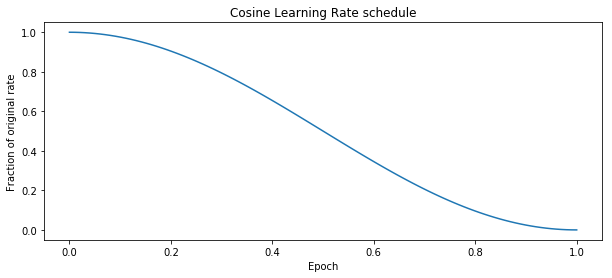

In [4]:
_= nnh.plot_cosine_lr()

# What took so long ?

We had briefly discussed this topic in a prior lecture.
We will now dive more deeply into the multitude of reasons for why it took so long for 
Deep Learning to achieve success.

An historical perspective:

- Perceptron invented 1957
- mid-1970's: First "AI Winter"
- Late 1980's: secibd "AI Winter"
- 2010: Re-emergence of AI

The promise of AI led to great expectations, that were ultimately unfulfilled.
The difficulty was the inability to train networks.

We now spend some time investigating the causes, and solutions, to the difficulty of training networks.

Broadly speaking the issues are
- proper scaling of the inputs
- initialization of learnable weights
- making sure that the proper scaling of inputs continues to each layer, not just the input

-
**TO DO**
Not a great transition.
- particularly arguing the need for zero-centered, unit variance: was known for a while
- Find a better way to introduce the following sections

# Proper scaling of inputs

## Importance of zero centered inputs (for each layer)
[Efficient Backprop paper, LeCunn98](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)

**Zero centered** means average (over the training set) value of each feature of examples is mean $0$.

Gradient descent updates each element of a layer $\ll$'s weights $\W_\llp$ by
the per-example losses 

$$
\begin{array}[lll] \\
\frac{\partial \loss^\ip }{\partial W_\llp} & = & \frac{\partial \loss^\ip}{\partial \y_\llp^\ip} \frac{\partial \y_\llp^\ip}{\partial \W_\llp} 
\end{array}
$$
summed over examples $i$.

Over-simplifying:
- the local derivative is proportional to the input:
$$
\frac{ \partial{\y_\llp^\ip} } { \partial \W_\llp } = a'_\llp \y_{(\ll-1)}^\ip
$$
for FC $y_\llp = a_\llp ( \y_{(\ll-1)} \W_\llp )$.
- thus the updates of $\W_{\llp,j}$ will be biased by $\bar{\y}_{(\ll-1),j}$ = the average (over examples $i$) of $\y_{(\ll-1),j}^\ip$
- for $\ll = 1$, this is the average of the input feature $\x_j$

In the particular case that each feature $j$'s average $\bar{\x}_j$ has the same sign:
- updates in all dimensions will have the same sign
- this can result in an indirect "zig-zag" toward the optimum
    - Exampe: two dimensions: 
        - We can navigate the loss surface north-east or south-west only ! 
        - To get to a point north-west from the current, we have to zig-zag.
        

- Note that this is an issue for *all* layers, not just layer $\ll =1$.

- Also note: the problem is compounded by activations whose outputs are not zero-centered (e.g., ReLU, sigmoid)

## Importance of unit variance inputs (weight initialization)

The same argument we made for zero-centering a feature can be extended to it's variance:
- the variance of feature $j$ over all trainng examples $i$ is the varaince of $\y_{(\ll-1),j}$

If the variance of features $j$ and $j'$ are different, their updates will happen at different rates.

We will examine this in greater depth during our discussion of weight initialization.

For now: it is desirable that the input to *each* layer have it's features somewhat normalized.


# Initialization

Training is all about discovering good weights.

As prosaic as it sounds: how do we *initialize* the weights before training ?
Does it matter ?

It turns out that the choice of initial weights does matter.

Let's start with some *bad* choices

## Bad choices

### Too big/small

Layers usually consist of linear operations (e.g., matrix multiplication and addition of bias)
followed by a non-linear activation.
The range of many activation functions includes large regions where the derivatives are near zero,
usually corresponding to very large/small activations.

The SGD update rule uses the magnitude of the gradient to update weights.
Obviously, if the gradients are all near-0, learning cannot occur.

So one bad choice is any set of weights that tends to push activations to regions of the non-linear
activation with zero gradient.

### Identical weights

Consider layer $\ll$ with $n_\ll$ units (neurons) implementing identical operations (e.g. FC + ReLu).

Let  $\W_{\llp, k}$ denote the weights of unit $k$.

Suppose we initialized the weights (and biases) of all units to the *same* vector.
$$
\W_{\llp, k} = \w_\llp, \; 1 \le k \le n_\ll
$$

Consider two neuron $j, j'$ in the same layer $\ll$
$$
\begin{array}[lll]\\
\y_{\llp, j}  & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\y_{\llp, j'} & = & a_\llp ( \w_\llp \y_{(\ll-1)} + \b_\llp ) \\
\end{array}
$$

- Both neuron will compute the same activation
- Both neurons will have the same gradient
- Both neurons will have the same weight update
 
Thus, the weights in layer $i$ will start off identical and will remain identical due to identical updates.

So identical initialization will lead to a failure for individual neurons to learn different features.

Many approaches use some for of random initialization to break the symmetry we just described.

## Glorot initialization

We have previousy shown that each element $j$ of the first input layer ($\x_{(0),j}$) should
have unit variance across the training set.  

This was meant to ensure that the first layer's weights
updated at the same rate and that the activations of the first layer fell into regions of the activation
function that had non-zero gradients.

But this is not enough.

Let's assume for the moment that each element $j$ of the input vector $\y_{(\ll-1)}$ is mean $0$, unit variance
and mutually independent.  

So view each $\y_{(\ll-1),j}$ as an independent random variable with mean $0$
and unit variance.  Furthermore, let's assome each element $\W_{\llp,j}$ is similarly distributed.

Consider the matrix multiplication in layer $\ll$ involving the $n_{\ll-1}$ output of layer $\ll$.
$$f_\llp(\y_{(\ll-1)}, W_\llp) = \y_{(\ll-1)} \cdot W_\llp$$

This expression is the weighted sum over $j$ of the product of
- a mean 0, unit variance random variable $\y_{(\ll-1),j}$
- a mean 0, unit variancerandom variable  $\W_{\llp,j}$

For two random variables $X, Y$, the variance of the product 
[is](https://en.wikipedia.org/wiki/Variance#Product_of_independent_variables)

$$
\text{Var}(XY) = \mathbb{E}(X)^2 \text{Var}(Y) + \mathbb{E}(Y)^2 \text{Var}(X) + \text{Var}(X)\text{Var}(Y)
$$

So 
$$\text{Var}(\y_{(\ll-1),j} \W_{\llp,j}) = 0^2 * 1 + 0^2 * 1 + 1 * 1 = 1
$$

Thus the variance of the dot product of $n_{\ll-1}$ products is $n_{\ll-1}$, not $1$ as desired.

However, by scaling each $\W_{\llp,j}$ by 
$$
\frac{1}{\sqrt{n_{\ll-1}}}
$$
the variance becomes $1$.

*Glorot* (also called *Xavier*) initialization sets the initial weights to a number drawn from 
mean $0$, unit variance distribution (either normal or uniform)
$\frac{1}{\sqrt{n_{\ll-1}}}
$.

Note that we don't strictly need the requirement of unit variance -- it works equally well as long
as the input and output variances are the same, which is the goal.

This only partially solves the problem as it only ensures unit variance of the input to the activation function.

The [original Glorot paper](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) justifies this
by assuming either a $\tanh$ or sigmoid activation functions and these functions can be approximated
as linear in the active region.

Thus far, we have achieved unit variance during the forward pass.
During back propagation, it was shown that the scaling factor depends on the number of outputs
of layer $\ll$, rather than number of inputs, so the scaling factor needs to be
$\frac{1}{\sqrt{n_\ll}}
$

Taking the average of the two scaling factors gives a final factor of
$\frac{1}{\sqrt{ \frac{ n_{\ll-1} + n_\ll}{2} } } = \sqrt{\frac{2}{n_{\ll-1} + n_\ll}}
$

## Kaiming/He initialization

[Kaiming et al](https://arxiv.org/pdf/1502.01852.pdf) extended the results of Glorot et. al
to the ReLU activation.

The ReLU activation has two distinct regions: one linear (for inputs greater than 0) and one all zero.

The linear region of the activation corresponds to the assumption of the Glorot method.

So if inputs to the ReLU are equally distributed around 0, this is approximately the same
as the Glorot method with half the number of inputs.
- that is: half of the ReLU's will be in the active region and half will be in the inactive region.

The Kaiming scaling factor is thus:
$$
\sqrt{\frac{2}{n_{(\ll-1)}} }
$$
in order to preserve unit variance.

## Layer-wise pre-training

We discussed this in the Autoencoder lecture.

In the absence of a "good" idea for initializing layer $\ll$'s weights
- train layer $\ll$ as an Autoencdoer
    - train it so that input $y_{(\ll-1)}$ has target $y_{(\ll-1)}$ 
    - this will result in weights $\W_\llp$ that have discovered some structure among the features $y_{(\ll-1)}$
    - Initialize the weights of layer $\ll$ to the ones produced by the Autoencoder
- These weights *may or may not* be useful in predicting $\hat{\y} = \y_{(L)}$
- But they are probably better than random weights

# Normalization

- We addressed the importance of normalization of the inputs to layer $\ll = 1$.
- The same argument applies to *all* layers $\ll > 0$

We discuss some Normalization methods that attempt to keep the distribution of $\y_{\llp,j}$
normalized through all layers $\ll$.


## Batch normalization
[Batch Normalization paper](https://arxiv.org/abs/1502.03167)

The idea behind batch normalization:
-  perform standardization  (mean $0$, standard deviation 1)
at each layer, using the mean and standard deviation of each minibatch.

- faciliates higher learning rate 
    - controlling the size of the derivative allows higher $\alpha$ without increasing product


Experimental results show that the technqiue:
- facilitates the use of much higher learning rates, thus speeding training.  Accuracy is not lost.
- facilitates the use of saturating activations functions (e.g., $\tanh$ and sigmoid) which otherwise are subject to vanishing/exploding gradients.
- acts as a regularizer; reduces the need for Dropout
    - L2 regularization (weight decay) has *no* regularizing effect when used with Batch Normalization !
        - [see](https://arxiv.org/abs/1706.05350)
        - L2 regularization affects scale of weights, and thereby learning rate

### Details

Consider a FC layer $\ll$ with $n_\ll$ outputs and a mini-batch of size $m_B$.

Each of the $n_\ll$ outputs is the result of
- passing a linear combination of $\y_{(\ll -1)}$ (*activation inputs*)
-  through an activation $a_{\llp,j}$ (*activation outputs*)

We could choose to standardize either the activation inputs or the activation outputs.

This algorithm standardizes the **activation inputs**.

Standardization is performed relative to the mean and standard deviation of each batch.




Summary for layer $\ll$ with equation $\y_\llp = a_\llp( \W_\llp \y_{(\ll-1)})$
- each output feature $j$: $\y_{\llp,j} = a_{\llp,j}( \W_{\llp,j} \y_{(\ll-1)})$

- Denote the dot product for output feature $j$ by $\x_{\llp,j} = \W_{\llp,} \y_{(\ll-1)}$
- We will replace $\x_{\llp,j}$ by a "standardized" $\z_{\llp,j}$ to be described

Rather than carrying along supscript $j$
we write all operations on  the collection $\x_{\llp,j}$ as a vector operation on $\x_\llp$ for ease of notation.



$
\begin{split}
1.\quad & \mathbf{\mu}_B = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{\mathbf{x}^{(i)}}\\
2.\quad & {\mathbf{\sigma}_B}^2 = \dfrac{1}{m_B}\sum\limits_{i=1}^{m_B}{(\mathbf{x}^{(i)} - \mathbf{\mu}_B)^2}\\
3.\quad & \hat{\mathbf{x}}^{(i)} = \dfrac{\mathbf{x}^{(i)} - \mathbf{\mu}_B}{\sqrt{{\mathbf{\sigma}_B}^2 + \epsilon}}\\
4.\quad & \mathbf{z}^{(i)} = \gamma \hat{\mathbf{x}}^{(i)} + \beta
\end{split}
$

So
- $\mathbf{\mu}_B, \mathbf{\sigma}_B$ are vectors (of length $n_\ll$) of 
    - the element-wise means and standard deviations (computed across the batch of $m_B$ examples)
- $\mathbf{\hat{x}^{(i)}}$ is standardized $\mathbf{x}^{(i)}$ 

** Note the $\epsilon$ in the denominator is their solely to prevent "divide by 0" errors

What is going on with $\z^\ip$ ?  

Why are we constructing it with mean $\beta$ and standard deviation $\gamma$ ?

$\beta, \gamma$ which are **learned** parameters.

Why should $\beta, \gamma$ be learned ?

At a minimum: it can't hurt:
- it admits the possibility of the identity transformation
    - which would be the simple standardization
- but allows the unit to be non-linear when there is a benefit

Moreover, depending on the activation $a_{\llp, j}$
- $\hat{\x}_{\llp,j}$ can wind up *within the active region* of the activation function

This effectively makes our transformations linear, rather than non-linear, which are more powerful.

By shifting the mean by $\beta$ we gain the *option* to avoid this should it be beneficial.


The final question is: what do we do at inference/test time, when all "batches" are of size 1 ?

The answer is
- compute a single $\mathbf{\mu}, \mathbf{\sigma}$ from the sequence of such values across all batches.
- "population" statistics (over full training set
- rather than "sample" statistics (from a single training batch).

Typically a moving average is used.
We refer readers to the paper.

We create a new layer type $\text{BN}$ to perform Batch Normalization to the inputs of any layer.

Thus, it particpates in both the forward (i.e., normalization) and backward (gradient computation)
steps.

# Unbelievably good initialization

Glorot and Kaiming weight initialization 
- ensures "good" distribution of outputs of a layer, given a good distribution of inputs to the layer

Normalization (e.g., Batch Normalization)
- tries to ensure good distribution of inputs across al layers

There are some initialization methods that attempt to create weights that are so good,
that Normalization during training is no longer necessary.

[Fixup initialization paper](https://arxiv.org/abs/1901.09321)
- good initialization means you don't need normalization layers

But good initialization can help too.
  
    


# How big should my NN be ?

There is a paradox in building Neural Networks:
- Start off training an overly large NN (many units)
- Many units turn out to be "dead": near zero weights
- Reduce the number of units
- Can't train !

Given a fixed number of layers: it is easier to train a big NN than a small one.

"Somewhere in this big mess must be something valuable"


<table>
    <tr>
        <th><center>"Big" NN with dead nodes</center></th>
    </tr>
    <tr>
        <td><img src=images/Dropout_NN_wo_dropout.jpg width=400></td>
    </tr>
</table>

<table>
    <tr>
        <th><center>"Big" NN after dead nodes have been pruned</center></th>
    </tr>
    <tr>
        <td><img src=images/Dropout_NN_w_dropout.jpg width=400></td>
    </tr>


[The Lottery Ticket Hypothesis](https://arxiv.org/abs/1803.03635)
is an interesting paper that addresses this issue.

For now:
- Use bigger than necessary NN's
- With regularization to "prune"


# Regularization

The ultimate goal of Machine Learning is out of sample prediction.

Because Neural Networks often learn a large number of parameters (weights), overfitting is a concern.

We will briefly review several methods to combat overfitting

## Cost function: add regularization penalty

The same methods that were applicable in Classical Machine Learning apply to Deep Learning as well.

These include regularization penalties that aim to reduce the number of parameters.
- L2 regularization
- L1 regularization

## Dropout

[Droput paper](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

Overfitting can occur because some weights in the NN adapt so as to memorize "noisy" features.

*Dropout* is a method that *randomly drops a unit in the NN*
- For each training example $\x^\ip$
- Each unit gets dropped with probability $p$
 


<table>
    <tr>
        <th><center>NN, no dropout</center></th>
    </tr>
    <tr>
        <td><img src=images/Dropout_NN_wo_dropout.jpg width=400></td>
    </tr>


<table>
    <tr>
        <th><center>NN, 50% dropout</center></th>
    </tr>
    <tr>
        <td><img src=images/Dropout_NN_w_dropout.jpg width=400></td>
    </tr>


A Neural Network with $N$ units contains $2^N$ possible sub-networks.

Dropout can be viewed as training many of these sub-networks (with weights shared by sub-networks.)

If a feature is truly important, the NN must adapt to robustly recognize the feature.

If it is not important, the goal is to prevent a unit from memorizing it.

In Keras, Dropout is implemented by a layer:

`Dropout(rate)`

where `rate` is the probability of dropping a unit.

Dropout has been supplanted by Batch Normalization, but is worth studying 
- for its simplicity and ease of use
- inspiration it offers.


## Data Augmentation 

It is sometimes possible to expand the training set in such a way as to discourage overfitting.

This usually involves 
creating variants of training examples
- make it hard to memorize them all.

### Input Transformation

Alter the image while preserving its label.

- Image transformation
    - rotate, crop, flip

### Label smoothing" reducing prediction confidence

[Label Smoothing paper](https://arxiv.org/pdf/1701.06548.pdf)

Recall our discussion about the difference between Cross Entropy and Hinge Loss
- Hinge Loss "stops trying" to improve parameters when they are just "good enough" to yield a correct prediction
- Cross Entropy: tries to improve probablity to exactly $0$ or $1$

Cross Entropy's relentless search for improvement may lead to poor out of sample generalization.

A class of solutions exists to discourage the NN from seeking absolute confidence in its prediction.

*Label Smoothing* changes binary targets to values that are only approximately $0$ or $1$.

| Example | Smoothed label
| :- | -----
| $(\x^\ip, 0)$ | $(\x^\ip, 0 + \epsilon)$
| $(\x^\ip, 1)$ | $(\x^\ip, 1 - \epsilon)$


So rather than using One Hot Encoding (OHE), we use "$\epsilon$ Hot Encoding"

## Mixup training
[Mixup training paper](https://arxiv.org/abs/1905.11001)

*Mixup training* is a second solution to prevent an NN from seeking absolute confidence.

It creates additional training examples that are *mixtures* of existing examples:


| &nbsp; &nbsp; &nbsp; &nbsp; Training example &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;         | Mixup ? 
|:--- | :--- 
| $(\x^\ip, \y^\ip)$ &nbsp; &nbsp; &nbsp;  &nbsp; | original
| $(\x^{(i')}, \y^{(i')})$ &nbsp; &nbsp; &nbsp; | original
| $(\x^\ip + \lambda \x^{(i')}, \y^\ip) + \lambda \y^{(i')})$ | Mixup


The mixing parameter $\lambda$ is best when it is close to $0$ or $1$
- $(0 + \epsilon)$ or $(1 - \epsilon)$.

In [5]:
print("Done")

Done
